# Targeted Training Notebook
A practical guide to the targeted training process. 

**Author:** Kalyan Dutia (kalyan.dutia@ibm.com)

Here we assume that you **already have your intents downloaded, in the `data/workspace_training` folder.** If you don't, you can manually download them or use the tool contained in the exploratory analysis notebook.

In [65]:
# external imports
import os
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
import pandas as pd
import numpy as np
import seaborn as sns
from itables import show
import logging
import time
import matplotlib.pyplot as plt

# internal imports
import config
from cli_tools.get_intent_intersections import intent_intersections
from conversation_test.kfoldtest import kfoldtest

# config
sns.set_style("whitegrid")
sns.set_context("notebook")
pd.set_option('display.max_colwidth', -1)

logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)


## Load a skill
If you can't see your skill here, check the `data/workspace_training` folder.

In [10]:
def onchange(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output()
        display(d)
        display_sample(d, 10)

def display_sample(d, samplesize):
    display(Markdown("**<span style='color:blue'>{}</span>** skill selected. Training data sample:".format(d.value)))
    training_file = training_files[d.index]

    train_df = pd.read_csv(os.path.join(config.training_dir, training_file), names=['utterance', 'intent'])
    if len(train_df) > 0:
        display(train_df.sample(samplesize))
    else:
        display(Markdown("<span style='color:red'>No intent training data exists for this workspace</span>"))
    
    return train_df

training_files = [file for file in os.listdir(config.training_dir) if file.endswith('.csv')]
d = widgets.Dropdown(options=[item[0:len(item)-14] for item in training_files])
d.observe(onchange)

display(d)
train_df = display_sample(d, 10)
intents = train_df['intent'].unique()

Dropdown(options=('puppy', 'Customer Care Sample Skill'), value='puppy')

**<span style='color:blue'>puppy</span>** skill selected. Training data sample:

,utterance,intent
114,Do I always need to buy my dog the same food,DOG_FOOD
84,does the puppies siblings get sick?,DOG_HEALTH
71,Can the dog see properly,DOG_HEALTH
104,how long does the mum wean her pups,DOG_PARENTS_INFORMATION
87,Can I interview the parents?,DOG_PARENTS_INFORMATION
66,my chow chow is not so well well,DOG_HEALTH
13,Where can I buy a dog,PURCHASE_DOG
1,I've looked at the pictures and I'm ready to buy a puppy.,PURCHASE_DOG
61,do dogs get depression,DOG_HEALTH
112,I have just got a litter of puppies and don't know if I can feed them anything but milk,DOG_FOOD


We also need the details of the workspace and instance in Watson:

In [3]:
# INSTANCE. Use one of apikey or username & password
apikey = "5XuD4BoYqV0Lx5PUltqzVnDue1MzCTgGcld8uCtPsNR_"
#username = 
#password = 
url = "https://gateway.watsonplatform.net/assistant/api/"

# WORKSPACE 
workspace_id = "e6b17f68-9a81-4ac6-ae18-231717a47d3a"
threshold = 0.4

# TEST PARAMS
nfolds = 3

## Run K-Fold test
In order to work out which intents to target, we first run a K-Fold test on our workspace.
You can also directly run one using the module in the `conversation_test` folder.

The kfold test returns:
- `results_kfold`: the classification per utterances
- `classification_report`: f1 score, precision and recall per intent, as well as averages
- `metrics_per_fold`: the same metrics, but for the entire workspace, per fold

In [4]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

kfold = kfoldtest(apikey=apikey, url=url, n_folds=nfolds, threshold=threshold)
kfold.intent_df_from_df(train_df)
results_kfold, classification_report, metrics_per_fold = kfold.full_run_kfold_from_df(train_df)

[2019-07-26 10:08:24,148] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): iam.bluemix.net:443
[2019-07-26 10:08:24,148] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): iam.bluemix.net:443
[2019-07-26 10:08:24,392] DEBUG (urllib3.connectionpool): https://iam.bluemix.net:443 "POST /identity/token HTTP/1.1" 200 1808
[2019-07-26 10:08:24,392] DEBUG (urllib3.connectionpool): https://iam.bluemix.net:443 "POST /identity/token HTTP/1.1" 200 1808
[2019-07-26 10:08:24,401] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:08:24,401] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:08:26,327] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "GET /assistant/api//v1/workspaces?version=2018-07-10 HTTP/1.1" 200 None
[2019-07-26 10:08:26,327] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "GET 

You have space to perform the k-fold test
fold num 1: train set: 89, test set: 47
fold num 2: train set: 91, test set: 45
fold num 3: train set: 92, test set: 44
creating K-FOLD workspace 1 out of 3


[2019-07-26 10:08:27,324] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces?version=2018-07-10 HTTP/1.1" 201 None
[2019-07-26 10:08:27,324] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces?version=2018-07-10 HTTP/1.1" 201 None
[2019-07-26 10:08:27,359] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:08:27,359] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443


creating K-FOLD workspace 2 out of 3


[2019-07-26 10:08:27,739] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces?version=2018-07-10 HTTP/1.1" 201 205
[2019-07-26 10:08:27,739] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces?version=2018-07-10 HTTP/1.1" 201 205
[2019-07-26 10:08:27,784] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:08:27,784] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443


creating K-FOLD workspace 3 out of 3


[2019-07-26 10:08:28,250] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces?version=2018-07-10 HTTP/1.1" 201 None
[2019-07-26 10:08:28,250] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces?version=2018-07-10 HTTP/1.1" 201 None
[2019-07-26 10:08:28,259] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:08:28,259] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443


Checking workspaces..


[2019-07-26 10:08:28,655] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "GET /assistant/api//v1/workspaces/f26bb75b-7f94-4995-aec6-e301900d2920?version=2018-07-10 HTTP/1.1" 200 220
[2019-07-26 10:08:28,655] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "GET /assistant/api//v1/workspaces/f26bb75b-7f94-4995-aec6-e301900d2920?version=2018-07-10 HTTP/1.1" 200 220
[2019-07-26 10:08:28,663] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:08:28,663] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:08:29,194] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "GET /assistant/api//v1/workspaces/5486135a-c94c-4d01-bcbb-a7377f461966?version=2018-07-10 HTTP/1.1" 200 222
[2019-07-26 10:08:29,194] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "GET /assistant/api//v1/workspaces/54

Checking workspaces..


[2019-07-26 10:08:49,891] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "GET /assistant/api//v1/workspaces/f26bb75b-7f94-4995-aec6-e301900d2920?version=2018-07-10 HTTP/1.1" 200 220
[2019-07-26 10:08:49,891] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "GET /assistant/api//v1/workspaces/f26bb75b-7f94-4995-aec6-e301900d2920?version=2018-07-10 HTTP/1.1" 200 220
[2019-07-26 10:08:49,902] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:08:49,902] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:08:50,245] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "GET /assistant/api//v1/workspaces/5486135a-c94c-4d01-bcbb-a7377f461966?version=2018-07-10 HTTP/1.1" 200 222
[2019-07-26 10:08:50,245] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "GET /assistant/api//v1/workspaces/54

Checking workspaces..


[2019-07-26 10:09:11,141] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "GET /assistant/api//v1/workspaces/f26bb75b-7f94-4995-aec6-e301900d2920?version=2018-07-10 HTTP/1.1" 200 224
[2019-07-26 10:09:11,141] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "GET /assistant/api//v1/workspaces/f26bb75b-7f94-4995-aec6-e301900d2920?version=2018-07-10 HTTP/1.1" 200 224
[2019-07-26 10:09:11,159] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:09:11,159] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443


Workspace f26bb75b-7f94-4995-aec6-e301900d2920 (1) available


[2019-07-26 10:09:11,591] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "GET /assistant/api//v1/workspaces/5486135a-c94c-4d01-bcbb-a7377f461966?version=2018-07-10 HTTP/1.1" 200 224
[2019-07-26 10:09:11,591] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "GET /assistant/api//v1/workspaces/5486135a-c94c-4d01-bcbb-a7377f461966?version=2018-07-10 HTTP/1.1" 200 224
[2019-07-26 10:09:11,602] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:09:11,602] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443


Workspace 5486135a-c94c-4d01-bcbb-a7377f461966 (2) available


[2019-07-26 10:09:12,097] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "GET /assistant/api//v1/workspaces/e5bec1bc-42a3-45eb-b09b-860e89a9c1e8?version=2018-07-10 HTTP/1.1" 200 221
[2019-07-26 10:09:12,097] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "GET /assistant/api//v1/workspaces/e5bec1bc-42a3-45eb-b09b-860e89a9c1e8?version=2018-07-10 HTTP/1.1" 200 221


Workspace e5bec1bc-42a3-45eb-b09b-860e89a9c1e8 (3) available


  0%|          | 0/47 [00:00<?, ?it/s][2019-07-26 10:09:32,130] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:09:32,130] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443




RUNNING K-FOLD FOR FOLD NUMBER 1


[2019-07-26 10:09:32,453] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/f26bb75b-7f94-4995-aec6-e301900d2920/message?version=2018-07-10 HTTP/1.1" 200 511
[2019-07-26 10:09:32,453] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/f26bb75b-7f94-4995-aec6-e301900d2920/message?version=2018-07-10 HTTP/1.1" 200 511

  2%|▏         | 1/47 [00:00<00:15,  2.90it/s][2019-07-26 10:09:32,481] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:09:32,481] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:09:32,849] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/f26bb75b-7f94-4995-aec6-e301900d2920/message?version=2018-07-10 HTTP/1.1" 200 None
[2019-07-26 10:09:32,849] DEBUG (urllib3.connectionpool): h

[2019-07-26 10:09:35,439] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:09:35,685] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/f26bb75b-7f94-4995-aec6-e301900d2920/message?version=2018-07-10 HTTP/1.1" 200 502
[2019-07-26 10:09:35,685] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/f26bb75b-7f94-4995-aec6-e301900d2920/message?version=2018-07-10 HTTP/1.1" 200 502

 21%|██▏       | 10/47 [00:03<00:12,  3.02it/s][2019-07-26 10:09:35,708] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:09:35,708] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:09:36,418] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/f26bb75b-7f94-499


 38%|███▊      | 18/47 [00:06<00:09,  3.03it/s][2019-07-26 10:09:38,977] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:09:38,977] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:09:39,423] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/f26bb75b-7f94-4995-aec6-e301900d2920/message?version=2018-07-10 HTTP/1.1" 200 None
[2019-07-26 10:09:39,423] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/f26bb75b-7f94-4995-aec6-e301900d2920/message?version=2018-07-10 HTTP/1.1" 200 None

 40%|████      | 19/47 [00:07<00:10,  2.68it/s][2019-07-26 10:09:39,453] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:09:39,453] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway

[2019-07-26 10:09:45,207] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/f26bb75b-7f94-4995-aec6-e301900d2920/message?version=2018-07-10 HTTP/1.1" 200 516

 57%|█████▋    | 27/47 [00:13<00:12,  1.63it/s][2019-07-26 10:09:45,234] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:09:45,234] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:09:45,516] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/f26bb75b-7f94-4995-aec6-e301900d2920/message?version=2018-07-10 HTTP/1.1" 200 511
[2019-07-26 10:09:45,516] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/f26bb75b-7f94-4995-aec6-e301900d2920/message?version=2018-07-10 HTTP/1.1" 200 511

 60%|█████▉    | 28/47 [00:13<00:09,  1.92it/s][2019-07-26

[2019-07-26 10:09:48,388] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/f26bb75b-7f94-4995-aec6-e301900d2920/message?version=2018-07-10 HTTP/1.1" 200 518
[2019-07-26 10:09:48,388] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/f26bb75b-7f94-4995-aec6-e301900d2920/message?version=2018-07-10 HTTP/1.1" 200 518

 77%|███████▋  | 36/47 [00:16<00:03,  2.96it/s][2019-07-26 10:09:48,407] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:09:48,407] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:09:48,719] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/f26bb75b-7f94-4995-aec6-e301900d2920/message?version=2018-07-10 HTTP/1.1" 200 515
[2019-07-26 10:09:48,719] DEBUG (urllib3.connectionpool): h

[2019-07-26 10:09:56,712] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:09:56,955] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/f26bb75b-7f94-4995-aec6-e301900d2920/message?version=2018-07-10 HTTP/1.1" 200 None
[2019-07-26 10:09:56,955] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/f26bb75b-7f94-4995-aec6-e301900d2920/message?version=2018-07-10 HTTP/1.1" 200 None

 96%|█████████▌| 45/47 [00:24<00:01,  1.21it/s][2019-07-26 10:09:56,977] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:09:56,977] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:09:57,559] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/f26bb75b-7f94-4



RUNNING K-FOLD FOR FOLD NUMBER 2


[2019-07-26 10:09:58,309] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/5486135a-c94c-4d01-bcbb-a7377f461966/message?version=2018-07-10 HTTP/1.1" 200 526
[2019-07-26 10:09:58,309] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/5486135a-c94c-4d01-bcbb-a7377f461966/message?version=2018-07-10 HTTP/1.1" 200 526

  2%|▏         | 1/45 [00:00<00:16,  2.72it/s][2019-07-26 10:09:58,326] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:09:58,326] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:09:58,895] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/5486135a-c94c-4d01-bcbb-a7377f461966/message?version=2018-07-10 HTTP/1.1" 200 508
[2019-07-26 10:09:58,895] DEBUG (urllib3.connectionpool): ht

[2019-07-26 10:10:04,005] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:04,322] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/5486135a-c94c-4d01-bcbb-a7377f461966/message?version=2018-07-10 HTTP/1.1" 200 None
[2019-07-26 10:10:04,322] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/5486135a-c94c-4d01-bcbb-a7377f461966/message?version=2018-07-10 HTTP/1.1" 200 None

 22%|██▏       | 10/45 [00:06<00:21,  1.63it/s][2019-07-26 10:10:04,338] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:04,338] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:04,577] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/5486135a-c94c-4


 40%|████      | 18/45 [00:11<00:19,  1.40it/s][2019-07-26 10:10:09,646] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:09,646] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:10,113] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/5486135a-c94c-4d01-bcbb-a7377f461966/message?version=2018-07-10 HTTP/1.1" 200 525
[2019-07-26 10:10:10,113] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/5486135a-c94c-4d01-bcbb-a7377f461966/message?version=2018-07-10 HTTP/1.1" 200 525

 42%|████▏     | 19/45 [00:12<00:16,  1.55it/s][2019-07-26 10:10:10,131] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:10,131] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.w

[2019-07-26 10:10:14,154] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/5486135a-c94c-4d01-bcbb-a7377f461966/message?version=2018-07-10 HTTP/1.1" 200 502

 60%|██████    | 27/45 [00:16<00:09,  1.84it/s][2019-07-26 10:10:14,178] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:14,178] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:14,792] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/5486135a-c94c-4d01-bcbb-a7377f461966/message?version=2018-07-10 HTTP/1.1" 200 509
[2019-07-26 10:10:14,792] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/5486135a-c94c-4d01-bcbb-a7377f461966/message?version=2018-07-10 HTTP/1.1" 200 509

 62%|██████▏   | 28/45 [00:16<00:09,  1.75it/s][2019-07-26

[2019-07-26 10:10:34,014] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/5486135a-c94c-4d01-bcbb-a7377f461966/message?version=2018-07-10 HTTP/1.1" 200 510
[2019-07-26 10:10:34,014] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/5486135a-c94c-4d01-bcbb-a7377f461966/message?version=2018-07-10 HTTP/1.1" 200 510

 80%|████████  | 36/45 [00:36<00:21,  2.40s/it][2019-07-26 10:10:34,112] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:34,112] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:34,429] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/5486135a-c94c-4d01-bcbb-a7377f461966/message?version=2018-07-10 HTTP/1.1" 200 None
[2019-07-26 10:10:34,429] DEBUG (urllib3.connectionpool): 

 98%|█████████▊| 44/45 [00:40<00:00,  1.72it/s][2019-07-26 10:10:38,229] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:38,229] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:38,606] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/5486135a-c94c-4d01-bcbb-a7377f461966/message?version=2018-07-10 HTTP/1.1" 200 504
[2019-07-26 10:10:38,606] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/5486135a-c94c-4d01-bcbb-a7377f461966/message?version=2018-07-10 HTTP/1.1" 200 504

  0%|          | 0/44 [00:00<?, ?it/s][2019-07-26 10:10:38,658] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:38,658] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatf



RUNNING K-FOLD FOR FOLD NUMBER 3


[2019-07-26 10:10:39,632] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/e5bec1bc-42a3-45eb-b09b-860e89a9c1e8/message?version=2018-07-10 HTTP/1.1" 200 None
[2019-07-26 10:10:39,632] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/e5bec1bc-42a3-45eb-b09b-860e89a9c1e8/message?version=2018-07-10 HTTP/1.1" 200 None

  2%|▏         | 1/44 [00:00<00:42,  1.01it/s][2019-07-26 10:10:39,653] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:39,653] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:40,012] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/e5bec1bc-42a3-45eb-b09b-860e89a9c1e8/message?version=2018-07-10 HTTP/1.1" 200 None
[2019-07-26 10:10:40,012] DEBUG (urllib3.connectionpool):

[2019-07-26 10:10:43,767] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:44,235] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/e5bec1bc-42a3-45eb-b09b-860e89a9c1e8/message?version=2018-07-10 HTTP/1.1" 200 None
[2019-07-26 10:10:44,235] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/e5bec1bc-42a3-45eb-b09b-860e89a9c1e8/message?version=2018-07-10 HTTP/1.1" 200 None

 23%|██▎       | 10/44 [00:05<00:19,  1.76it/s][2019-07-26 10:10:44,275] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:44,275] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:44,688] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/e5bec1bc-42a3-4


 41%|████      | 18/44 [00:08<00:10,  2.51it/s][2019-07-26 10:10:47,388] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:47,388] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:47,841] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/e5bec1bc-42a3-45eb-b09b-860e89a9c1e8/message?version=2018-07-10 HTTP/1.1" 200 None
[2019-07-26 10:10:47,841] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/e5bec1bc-42a3-45eb-b09b-860e89a9c1e8/message?version=2018-07-10 HTTP/1.1" 200 None

 43%|████▎     | 19/44 [00:09<00:10,  2.38it/s][2019-07-26 10:10:47,863] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:47,863] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway

[2019-07-26 10:10:51,061] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/e5bec1bc-42a3-45eb-b09b-860e89a9c1e8/message?version=2018-07-10 HTTP/1.1" 200 None

 61%|██████▏   | 27/44 [00:12<00:06,  2.59it/s][2019-07-26 10:10:51,078] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:51,078] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:51,572] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/e5bec1bc-42a3-45eb-b09b-860e89a9c1e8/message?version=2018-07-10 HTTP/1.1" 200 524
[2019-07-26 10:10:51,572] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/e5bec1bc-42a3-45eb-b09b-860e89a9c1e8/message?version=2018-07-10 HTTP/1.1" 200 524

 64%|██████▎   | 28/44 [00:12<00:06,  2.36it/s][2019-07-2

[2019-07-26 10:10:56,510] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/e5bec1bc-42a3-45eb-b09b-860e89a9c1e8/message?version=2018-07-10 HTTP/1.1" 200 None
[2019-07-26 10:10:56,510] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/e5bec1bc-42a3-45eb-b09b-860e89a9c1e8/message?version=2018-07-10 HTTP/1.1" 200 None

 82%|████████▏ | 36/44 [00:17<00:03,  2.05it/s][2019-07-26 10:10:56,560] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:56,560] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:10:57,010] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "POST /assistant/api//v1/workspaces/e5bec1bc-42a3-45eb-b09b-860e89a9c1e8/message?version=2018-07-10 HTTP/1.1" 200 506
[2019-07-26 10:10:57,010] DEBUG (urllib3.connectionpool):

100%|██████████| 3/3 [01:28<00:00, 27.65s/it]s]




FINISHED


[2019-07-26 10:11:00,875] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:11:00,875] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443


deleting workspace 1 out of 3: f26bb75b-7f94-4995-aec6-e301900d2920


[2019-07-26 10:11:01,465] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "DELETE /assistant/api//v1/workspaces/f26bb75b-7f94-4995-aec6-e301900d2920?version=2018-07-10 HTTP/1.1" 200 None
[2019-07-26 10:11:01,465] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "DELETE /assistant/api//v1/workspaces/f26bb75b-7f94-4995-aec6-e301900d2920?version=2018-07-10 HTTP/1.1" 200 None
[2019-07-26 10:11:01,473] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:11:01,473] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443


deleting workspace 2 out of 3: 5486135a-c94c-4d01-bcbb-a7377f461966


[2019-07-26 10:11:02,115] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "DELETE /assistant/api//v1/workspaces/5486135a-c94c-4d01-bcbb-a7377f461966?version=2018-07-10 HTTP/1.1" 200 None
[2019-07-26 10:11:02,115] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "DELETE /assistant/api//v1/workspaces/5486135a-c94c-4d01-bcbb-a7377f461966?version=2018-07-10 HTTP/1.1" 200 None
[2019-07-26 10:11:02,124] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443
[2019-07-26 10:11:02,124] DEBUG (urllib3.connectionpool): Starting new HTTPS connection (1): gateway.watsonplatform.net:443


deleting workspace 3 out of 3: e5bec1bc-42a3-45eb-b09b-860e89a9c1e8


[2019-07-26 10:11:02,551] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "DELETE /assistant/api//v1/workspaces/e5bec1bc-42a3-45eb-b09b-860e89a9c1e8?version=2018-07-10 HTTP/1.1" 200 28
[2019-07-26 10:11:02,551] DEBUG (urllib3.connectionpool): https://gateway.watsonplatform.net:443 "DELETE /assistant/api//v1/workspaces/e5bec1bc-42a3-45eb-b09b-860e89a9c1e8?version=2018-07-10 HTTP/1.1" 200 28


### View worst performing intents
We'll first choose a metric, then create a CSV showing the worst performing intents which can be used for annotation throughout this process.

In [47]:
display(Markdown("Now, we need to <span style='color:blue'>choose which metric to prioritise for this workspace.</span>" 

"\n \n If FPs and FNs are equally negative, then you may want to look at F1 score. More on this in **Section x** of the training at scale guide."

"\n \n**Preferred metric:**"))
        
d_m = widgets.Dropdown(options=['precision', 'recall', 'f1-score'])
display(d_m)

Now, we need to <span style='color:blue'>choose which metric to prioritise for this workspace.</span>
 
 If FPs and FNs are equally negative, then you may want to look at F1 score. More on this in **Section x** of the training at scale guide.
 
**Preferred metric:**

Dropdown(options=('precision', 'recall', 'f1-score'), value='precision')

In [52]:
cl_rep_export = classification_report.loc[intents, :].sort_values(d_m.value, ascending=True)
cl_rep_export = cl_rep_export.drop(columns='support')

intent_sizes = train_df.groupby('intent').count()
cl_rep_export['train_size'] = intent_sizes

cl_rep_export['comment'] = ""
cl_rep_export['action'] = ""

timestr = time.strftime("%Y%m%d-%H%M")
filename = d.value + '_kfold_results_' + timestr + '.csv'
output_path = os.path.join(config.output_folder, filename)
cl_rep_export.to_csv(output_path)

display(Markdown("We can then view K-fold results sorted by this metric, with a column added to show the size of the training set, and a couple more for annotation."))
display(Markdown("These results have been exported to <span style='color:blue'>{}</span> for annotation throughout the targeted training process.".format(output_path)))
display(cl_rep_export)



We can then view K-fold results sorted by this metric, with a column added to show the size of the training set, and a couple more for annotation.

These results have been exported to <span style='color:blue'>/Users/kalyan/Documents/practice-cog/intent_training_tools/results/precision_kfold_results_20190726-1045.csv</span> for annotation throughout the targeted training process.

,f1-score,precision,recall,train_size,comment,action
DOG_HEALTH,0.745763,0.758621,0.733333,29,,
PURCHASE_DOG,0.842105,0.857143,0.827586,28,,
DOG_PARENTS_INFORMATION,0.851064,0.833333,0.869565,24,,
DOG_VACCINATIONS,0.750000,0.642857,0.900000,28,,
DOG_FOOD,0.923077,0.888889,0.960000,27,,


In [58]:
melt_df = cl_rep_export.reset_index().melt(id_vars=['index'], value_vars=['f1-score', 'precision', 'recall'])
melt_df

,index,variable,value
0,DOG_HEALTH,f1-score,0.745763
1,PURCHASE_DOG,f1-score,0.842105
2,DOG_PARENTS_INFORMATION,f1-score,0.851064
3,DOG_VACCINATIONS,f1-score,0.750000
4,DOG_FOOD,f1-score,0.923077
5,DOG_HEALTH,precision,0.758621
6,PURCHASE_DOG,precision,0.857143
7,DOG_PARENTS_INFORMATION,precision,0.833333
8,DOG_VACCINATIONS,precision,0.642857
9,DOG_FOOD,precision,0.888889


We can also view a plot of these.

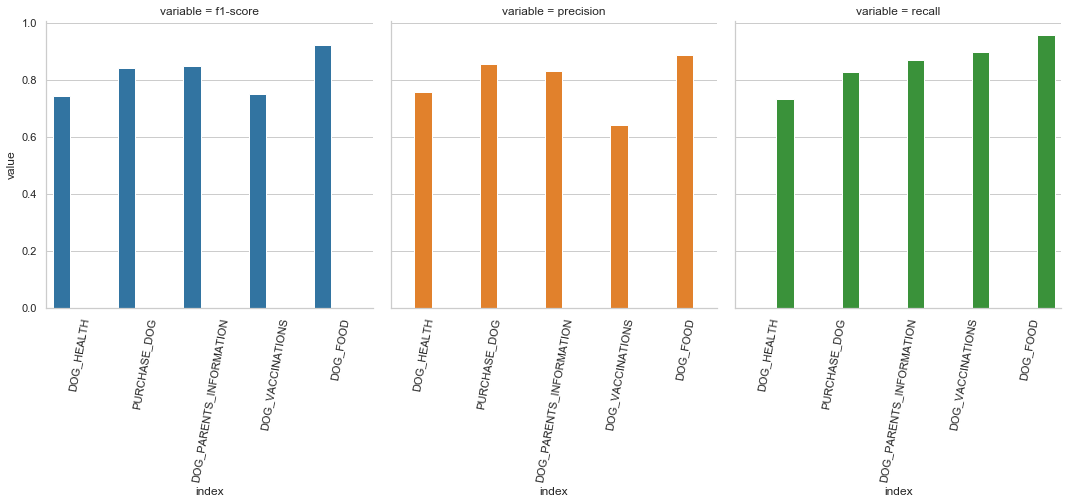

In [73]:
display(Markdown("We can also view a plot of these."))
ax = sns.catplot(data=melt_df, x='index', y='value', col='variable', kind='bar', hue="variable")
[plt.setp(ax.get_xticklabels(), rotation=80) for ax in ax.axes.flat];

## Analysis
The next stage is to write some comments and actions for the training that is needed. To do this we'll use the tools in this section.

### More training?
A common sign that an intent needs more training is that it has **low recall**: it is commonly not matching intents with enough confidence to provide a response. To test for this we can plot recall against training set size for our intents. 

You should investigate any intents which fall on the bottom left hand size of this plot as candidates for getting more training.

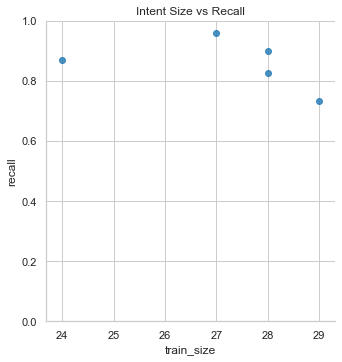

In [88]:
ax = sns.lmplot(data=cl_rep_export, x='train_size', y='recall', fit_reg=False)
ax.axes[0,0].set_title('Intent Size vs Recall')
ax.axes[0,0].set_ylim(0,1);

### Clashes Between Intents
Here we'll use tools to find overlapping phrases between intents that may be causing confusion between them. 

Change the parameters in the next cell to choose the length of the ngrams being searched for, and whether to remove stopwords.

In [89]:
ngram_list = [4,5] 
stopwords = 'none' # stopwords_in can be none, nltk, or config

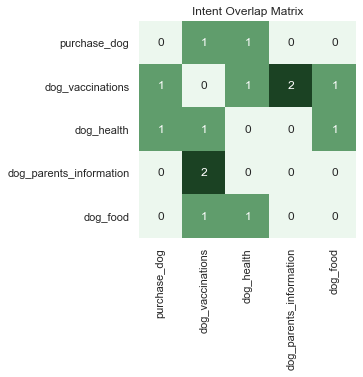

In [92]:
ii = intent_intersections(ngram_list, stopwords_in=stopwords, intent_col='intent')
ii.import_training_df(train_df)
intersection_df, intersection_size_df = ii.calculate_ngram_intersections()

intersection_size_df = intersection_size_df.fillna(0)
heatmap_colors = sns.cubehelix_palette(8, start=2, rot=0, dark=0.2, light=.95, reverse=False)
ax = sns.heatmap(intersection_size_df, annot=True, cmap=heatmap_colors, cbar=False, square=True)
ax.set_title('Intent Overlap Matrix');

Next, we can look into specific overlaps:

In [93]:
def onchange(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output()
        display(d01)
        display(d02)
        display_intent_overlap(d01.value, d02.value)

def display_intent_overlap(intent1, intent2):
    if d01.value != d02.value:
        ngrams_per_intent_df, ngram_freq_df = ii.get_ngrams_per_intent()
        overlap_df = ii.get_intersection_freqs([intent1, intent2], ngram_freq_df)
        overlap_df = overlap_df.sort_values([intent1, intent2], ascending=False)
        display(overlap_df)
    else:
        display(Markdown("Intents chosen can't be the same"))

d01 = widgets.Dropdown(options=train_df['intent'].unique())
d02 = widgets.Dropdown(options=train_df['intent'].unique())

d01.observe(onchange)
d02.observe(onchange)

display(d01)
display(d02)
display_intent_overlap(d01.value, d02.value)

Dropdown(options=('purchase_dog', 'dog_vaccinations', 'dog_health', 'dog_parents_information', 'dog_food'), va…

Dropdown(index=1, options=('purchase_dog', 'dog_vaccinations', 'dog_health', 'dog_parents_information', 'dog_f…

,purchase_dog,dog_vaccinations
i want to get,1.0,1.0


In [94]:
display(Markdown("You can use the table below to search through training utterances."))
show(train_df[['utterance', 'intent']])

You can use the table below to search through training utterances.

utterance,intent


## Training

We've currently got no tools to help here due to the differences in logs for each bot orchestrator. 

However, we can recommend two methods: **guided learning**, and **active learning**.

<span style="color:red">FILL IN AND REFER TO PAPER</span>